<center style="font-weight:bold;font-size:26px">Pericolo - Marker Detection - Aruco </center>

# Setup

## Imports

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [3]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [4]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

In [5]:
def read_img(filename, engine='cv'):
    if engine == 'cv':
        img = cv2.imread(filename)
    elif engine == 'skimage':
        img = io.imread(filename)
    return img

In [6]:
def get_img(df, idx, engine='cv'):
    print(df.loc[idx].file)
    return read_img(os.path.join(IMG_FOLDER, df.loc[idx].file), engine=engine)

## Plot functions

In [7]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [8]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

## Mask generation

In [9]:
def polygon_to_mask(width, height, polygon):
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    return np.array(img)

In [10]:
def IoU(mask_a, mask_b):
    I = mask_a * mask_b
    U = (mask_a + mask_b).clip(max=1)
    IOU = I.sum() / U.sum()
    return IOU

In [11]:
def inclusion_ratio(small_mask, large_mask):
    I = small_mask * large_mask
    ratio = I.sum() / small_mask.sum()
    return ratio

## Detector functions

In [12]:
def drawer_detector(QueryImgBGR, trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        print("Match Found")
        return trainBorder, queryBorder
    else:
        print("Not Enough match found-")
        print(len(goodMatch),MIN_MATCH_COUNT)
        return None

In [13]:
def train_sift(train_img, compute_img=False, fsize=(8,8)):
    FLANN_INDEX_KDITREE=0
    flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    flann=cv2.FlannBasedMatcher(flannParam,{})
    
    # Training
    sift_detector=cv2.xfeatures2d.SIFT_create()
    sift_trainImg= train_img.copy()
    sift_trainKP,sift_trainDesc=sift_detector.detectAndCompute(sift_trainImg,None)
    if compute_img:
        sift_trainImg1=cv2.drawKeypoints(sift_trainImg,sift_trainKP,None,(255,0,0),4)
        print("Detector Result on Train Image")
        imshow(sift_trainImg1, figsize=fsize)
        
    return sift_detector, sift_trainKP, sift_trainDesc, flann

In [14]:
def query_sift(query_img, sift_detector, sift_trainDesc, flann):
    #Querying
    sift_QueryImgBGR = query_img.copy()
    sift_QueryImg=cv2.cvtColor(sift_QueryImgBGR,cv2.COLOR_BGR2GRAY)
    sift_queryKP,sift_queryDesc=sift_detector.detectAndCompute(sift_QueryImg,None)
    sift_matches=flann.knnMatch(sift_queryDesc,sift_trainDesc,k=2)
    sift_goodMatch=[]
    
    for m,n in sift_matches:
        if(m.distance<0.75*n.distance):
            sift_goodMatch.append(m)
    print(f"Found matches: {len(sift_goodMatch)}")
    return sift_goodMatch, sift_queryKP, sift_queryDesc

In [15]:
def compute_detector_corners(trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        return trainBorder, queryBorder
    else:
        print("Not Enough match found")
        return [], [] 

In [16]:
def draw_detector_borders(image, queryBorder, color=(0,255,0), thickness=5, draw=True, figsize=(8,8)):
    QueryImgBGR = image.copy()
    cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,color,thickness)
    if draw:
        imshow(QueryImgBGR, figsize=figsize)
    return QueryImgBGR

## Warp functions

In [17]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [18]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [19]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [20]:
def infer_warp_shape(image, vp1, vp2, clip=False, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)
    
    max_x = int(max_x)
    max_y = int(max_y)
    
    return max_x, max_y

In [21]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

In [22]:
def ransac(locations, directions, strengths, num_ransac_iter=2000, threshold_inlier=5):
    lines = to_homogenous_geometry(locations, directions, strengths) # convert to homogenous geometry

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5] # Select the top 20 percentile
    second_index_space = arg_sort[:num_pts // 2] # Select the top 50 percentile

    best_model = None
    best_votes = np.zeros(num_pts)

    # Sampling process
    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space) # Sample a line from the top 20 percentile
        ind2 = np.random.choice(second_index_space) # Sample a line from the top 50 percentile

        l1 = lines[ind1]
        l2 = lines[ind2]

        # In Homogenous geometry the cross-product (vectot product)
        # represents the intersection points between two vectors
        current_model = np.cross(l1, l2)
        
        # In case of degeneracy
        # e.g colinearity between l1 and l2
        # e.g sampling where l1 and l2 are the same line
        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # Force resampling
            continue

        # Represent Vanishing Point (Intersection Point) in (X, Y, 1) Initial Plane
        vp = current_model[:2] / current_model[2]
        
        # For each edgelet compute the angle between the direction vector
        # and the vector defined as edgelet location minus vanishing point
        est_directions = locations - vp
        dot_prod = np.sum(est_directions * directions, axis=1)
        abs_prod = np.linalg.norm(directions, axis=1) * np.linalg.norm(est_directions, axis=1)
        abs_prod[abs_prod == 0] = 1e-5
        threshold_inlier = 5
        cosine_theta = dot_prod / abs_prod
        theta = np.arccos(np.abs(cosine_theta))
        
        # Consider for scoring only the edglets within a range of +/- threshold_inlier
        theta_thresh = threshold_inlier * np.pi / 180
        # The score is equal to the sum of edgelet's strength falling in the threshold range
        current_votes = (theta < theta_thresh) * strengths
        
        # In case the new model is better, replace the old one
        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            print("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))
    return best_model

In [23]:
def marker_position_in_projection(image, vp1, vp2, aruco_borders,clip=True, clip_factor=3):
    """Warp the perspective of an image given a set of vanishing points
    
    Args:
    -----
        image (np.array): Image to Warp (`RGB`/`BGR`/`GRAYSCALE`)
        vp1 (np.array): First vanishing point description
        vp2 (np.array): Second vanishing point description
        clip (bool, optional): Whether to clip or not the image. Defaults to False.
        clip_factor (int, optional): In case of clipping, which factor to apply. Defaults to 3.
    
    Returns:
    --------
        np.array: Warped image

    Note:
    -----
    In case you do not activate the clipping and the image has a strong perspective,
    the resulting warped image might have a huge size. Hence, it might slow the computation.
    """
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)


    marker_edges = [
        [aruco_borders[0][0], aruco_borders[1][0], aruco_borders[2][0], aruco_borders[3][0]],
        [aruco_borders[0][1], aruco_borders[1][1], aruco_borders[2][1], aruco_borders[3][1]],
        [1, 1, 1, 1]
    ]

    # Generate the marker position in the new projection
    marker_positions = np.dot(final_homography, marker_edges)
    marker_positions = (np.array(marker_positions) / np.array(marker_positions)[2])[:2].transpose()

    return order_points(marker_positions)

# Bibliography & Documentation

## Aruco

[Aruco Library Documentation](https://docs.google.com/document/d/1QU9KoBtjSM2kF6ITOjQ76xqL7H0TEtXriJX5kwi9Kgc/edit)

ArUco is an OpenSource library for detecting squared fiducial markers in images. Additionally, if you know the marker dimension, you can estimate distances on the with respect to the markers. 

In Python, Aruco generation and detection is part of the `cv2.aruco` package. Pre-built functions and methods allows for detection of markers on images and camera calibration. 

[Aruco Basics in Python](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html)

[OpenCV Aruco Documentation](https://docs.opencv.org/master/d9/d6a/group__aruco.html)

## SIFT

SIFT, for _Scale Invariant Feature Transform_ , is a feature detection algorithm in computer vision to detect and describe local features in images. It is based on a feature detection by application of iterative convolution differences to obtain very expressive features. We usually compute those feature on a train image, image showing the element we want to detect as clear as possible _(no noise, no alteration)_.

Since we now have a feature profile for our train image, we apply the feature detection in the query image, scene we want to investigate to find the previous element. We now have the feature profile of our query image. 

We, then, a matcher on both feature sets, usually a nearest neighbor algorithm to make a correspondance between the train and query features. The higher the matches, the higher the algorithm confidence.

Last of all we now want to obtain area of interest in the query image. It is done by an affine transformation $M$ generated via a least square solving. For $A_{T}(x, y)$ in Train image corresponding to $A_{Q}(u, v)$ in Query image, we should have the following relationship:

$$A_{Q} = M\cdot A_{Q} + b  \rightarrow \begin{bmatrix}
    u \\
    v
  \end{bmatrix} = \begin{bmatrix}
    a & b \\
    c & d
  \end{bmatrix}\begin{bmatrix}
    x \\
    y
  \end{bmatrix} + \begin{bmatrix}
    \alpha \\
    \beta
  \end{bmatrix}$$
 
Where $a,b,c,d,\alpha,\beta$ are the parameters to fit thanks to every found matches.

Once we have found the matrix $M$ we are able to find the element coordinates in the query image.

# Main Code

## Initialisation

Under the `data` folder we have created an `enclosed` folder to distinguish sample images with enclosed markers

In [24]:
os.listdir(os.path.join(DATA_FOLDER, 'enclosed'))

['.DS_Store',
 '20200108_023216.jpg',
 '20200108_023411.jpg',
 '20200108_023201.jpg',
 '20200108_023207.jpg',
 '20200108_023419.jpg',
 '20200108_023223.jpg',
 '20200108_023344.jpg',
 '20200108_023232.jpg',
 '20200108_023332.jpg',
 '20200108_023327.jpg',
 '20200108_023319.jpg']

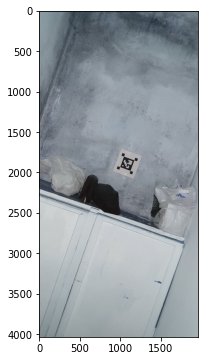

In [434]:
# Good SIFT + Aruco '20200108_023223.jpg', '20200108_023419.jpg', '20200108_023411.jpg', '20200108_023216.jpg'
# Less Acurate Warp '20200108_023201.jpg'
# Bad SIFT Good Aruco: '20200108_023232.jpg'
# No detection: '20200108_023344.jpg'
image = cv2.imread(os.path.join(DATA_FOLDER, 'enclosed','20200108_023419.jpg'))
imshow(image)

## Marker detection

### Aruco Built-in OpenCV methods

We use the snippets provided in [Aruco Basics in Python](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html) to check for Aruco markers in the scene

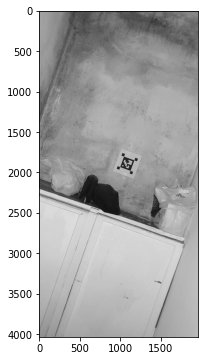

In [435]:
# Aurco detection is performed on GRAYSCALE images, we start by converting our input image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray, cmap='gray')

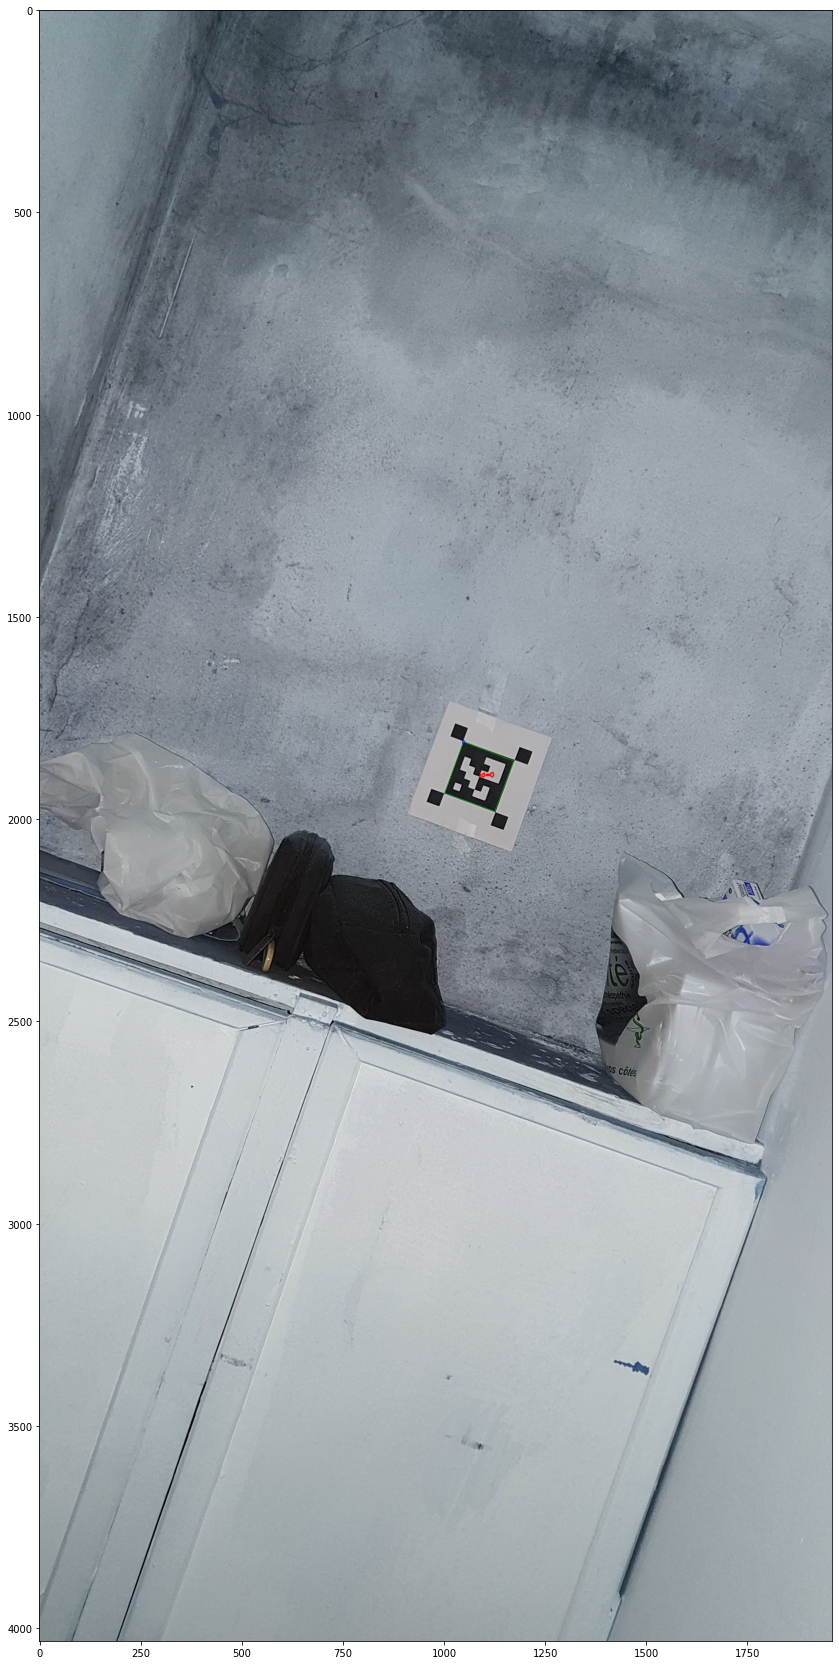

In [436]:
# We call a predefined dictionnary to sample Aruco Markers
# Here we choose a dictionnary containing 1000 markers with 6 by 6 grid
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_1000)
parameters =  aruco.DetectorParameters_create()
# We use the detectMarkers from aruco package in OpenCv to generate markers position and ids
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
# The following lines of codes are for display purpose only
frame_markers = aruco.drawDetectedMarkers(image.copy(), corners, ids,)
imshow(frame_markers, (30,30))

The corners found in the image for the enclosed marker are now ordered with the `order_points` function. This function sorts the points/corners to map them as follow: `[top_left, top_right, bottom_right, bottom_left]`. Thus allowing us to generate a mask for the Aruco marker.

In [437]:
corners_ordered = [order_points(marker[0]) for marker in corners]

### SIFT detection

We set an arbitrary `MIN_MATCH_COUNT` threshold to determine whether or not the SIFT detection can be relied on.

The following sequence is easily readable:
- We load the SIFT generated marker as a GRAYSCALE image
- We train our SIFT detector
- We query our previously trained SIFT detector to find the pattern in the scene

#### Full enclosed marker

For the first SIFT detection, we try to detect the full encapsulated marker. Having a strong confidence on where the full marker is on the scene will allow us to build a nice confidence index with regard to the Aruco detection _(Inclusion ratio metric)_.

Detector Result on Train Image


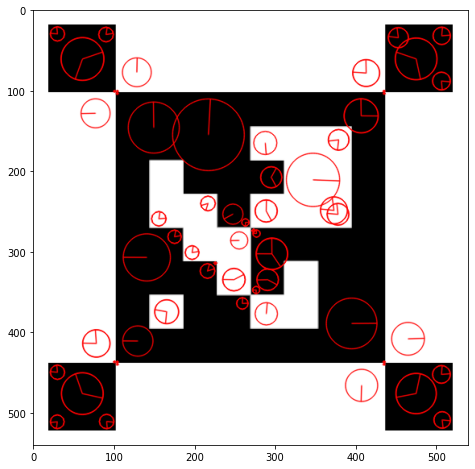

Found matches: 51


In [438]:
MIN_MATCH_COUNT = 15
enclosed_marker_train_img = cv2.imread(
    os.path.join(ROOT_FOLDER, 'markers', 'single_aruco_marker_enclosed_id0.png'),0
)
sift_detector, sift_trainKP, sift_trainDesc, flann = train_sift(enclosed_marker_train_img, compute_img=True)
sift_goodMatch, sift_queryKP, sift_queryDesc = query_sift(image.copy(), sift_detector, sift_trainDesc, flann)

The more the found matches, the heavier the detection confidence. As a general rule we can assume:
- `0<=found_matches<15` **Unreliable** detection (not to be used)
- `15<=found_matches<30` **Very weak** detection (to use with caution, permissive but not accurate)
- `30<=found_matches<50` **Moderate** confidence (to be used)
- `50<=found_matches` **Strong** confidence (to be used)

These ranges are to be considered only with regard to the training image we used. They might differ from one training image to another

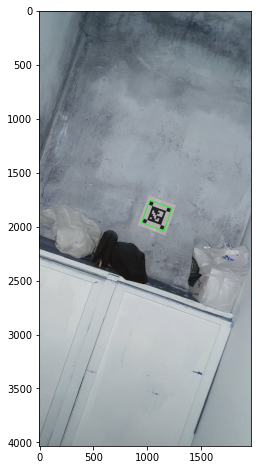

In [439]:
# Since the query has found an adequate number of matches we can compute the board corners
sift_trainBorder, sift_queryBorder_enclosed = compute_detector_corners(
    enclosed_marker_train_img, sift_goodMatch, sift_trainKP, sift_queryKP, force_true = False
)
# Function for display purpose only
sift_detection_img = draw_detector_borders(
    image, sift_queryBorder_enclosed, color=(0,255,0), thickness=5, draw=True)

#### Only Aruco marker

Our second SIFT detection only focus on the Aruco marker. Detecting it with a SIFT detector will allox us to compare the detected area with the Aruco detection to confirm our intuition.

Detector Result on Train Image


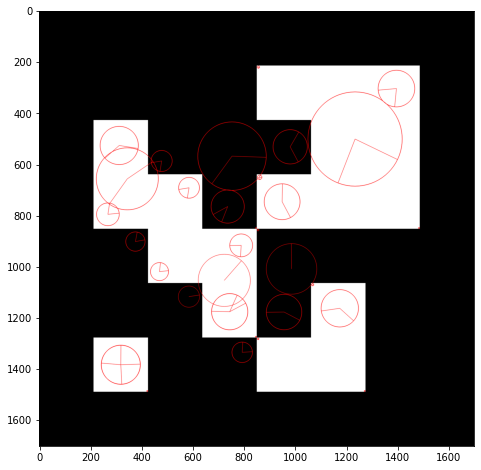

Found matches: 72


In [440]:
MIN_MATCH_COUNT = 15
enclosed_marker_train_img = cv2.imread(
    os.path.join(ROOT_FOLDER, 'markers', 'single_aruco_marker_id0.png'),0
)
sift_detector, sift_trainKP, sift_trainDesc, flann = train_sift(enclosed_marker_train_img, compute_img=True)
sift_goodMatch, sift_queryKP, sift_queryDesc = query_sift(image.copy(), sift_detector, sift_trainDesc, flann)

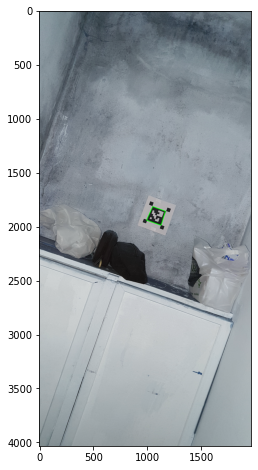

In [441]:
sift_trainBorder, sift_queryBorder_unenclosed = compute_detector_corners(
    enclosed_marker_train_img, sift_goodMatch, sift_trainKP, sift_queryKP, force_true = False
)
sift_detection_img = draw_detector_borders(
    image, sift_queryBorder_unenclosed, color=(0,255,0), thickness=5, draw=True
)

#### Mask Combination & Statistics

On the following image we plot the <span style="color:green">**SIFT Detected Marker _(only)_**</span>, the <span style="color:red">**SIFT Detected Marker _(encapsulated)_**</span> and the <span style="color:blue">**Aruco Detected Marker _(only)_**</span>

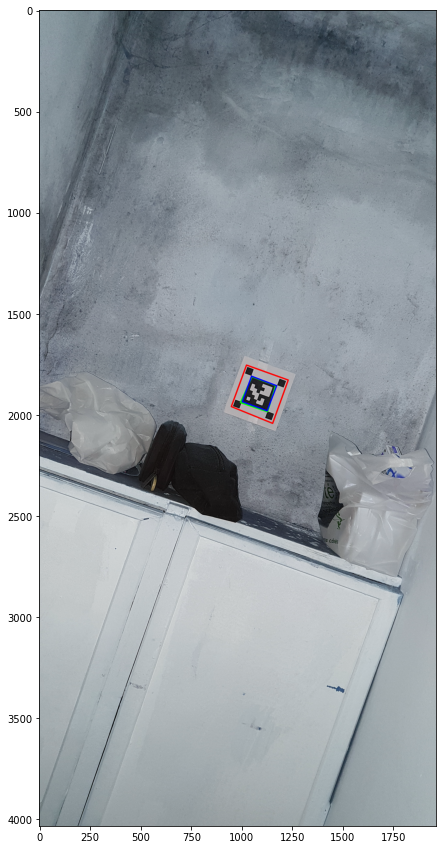

In [442]:
# Contour plotting
detector_image = draw_detector_borders(
    image, 
    sift_queryBorder_unenclosed, 
    color=(0,255,0), 
    thickness=5, 
    draw=False)
detector_image = draw_detector_borders(
    detector_image, 
    sift_queryBorder_enclosed, 
    color=(255,0,0), 
    thickness=5, 
    draw=False)
detector_image = draw_detector_borders(
    detector_image, 
    (corners[0] if len(corners) else corners), 
    color=(0,0,255), 
    thickness=5, 
    draw=True,
    figsize=(15, 15)
)

A strong heuristic to confirm the detection is to focus our analysis on two metrics:
- The Intersection over Union between the Aruco and SIFT detected marker _(unenclosed)_
    - For an `IoU > 90%` we can assume that the two region are very similar
- The Inclusion ratio between the previous areas and the SIFT detected enclosed marker
    - Confirming if the detected unenclosed marker is really inside the enclosed area
    - An inclusion rate lower than 99% should be suspicious

In [412]:
enclosed_mask = polygon_to_mask(image.shape[1], image.shape[0],sift_queryBorder_enclosed)
unenclosed_mask = polygon_to_mask(image.shape[1], image.shape[0],sift_queryBorder_unenclosed)
aruco_mask = (polygon_to_mask(image.shape[1], image.shape[0],corners[0]) if len(corners) else np.zeros_like(gray))
print(f"Intersection Over Union (Enclosed Vs Unenclosed): {IoU(enclosed_mask, unenclosed_mask)*100}%")
print(f"Intersection Over Union (Enclosed Vs Aruco): {IoU(aruco_mask, enclosed_mask)*100}%")
print(f"Intersection Over Union (Unenclosed Vs Aruco): {IoU(aruco_mask, unenclosed_mask)*100}%")
print(f"Inclusion Ratio (Enclosed Vs Unenclosed): {inclusion_ratio(unenclosed_mask, enclosed_mask)*100}%")
print(f"Inclusion Ratio (Enclosed Vs Aruco): {inclusion_ratio(aruco_mask, enclosed_mask)*100}%")

Intersection Over Union (Enclosed Vs Unenclosed): 38.21485266064592%
Intersection Over Union (Enclosed Vs Aruco): 38.10813334578392%
Intersection Over Union (Unenclosed Vs Aruco): 96.79427647645582%
Inclusion Ratio (Enclosed Vs Unenclosed): 100.0%
Inclusion Ratio (Enclosed Vs Aruco): 100.0%


ENCLOSED MARKER


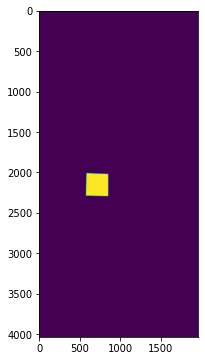

UNENCLOSED MARKER


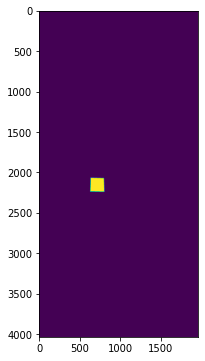

ARUCO


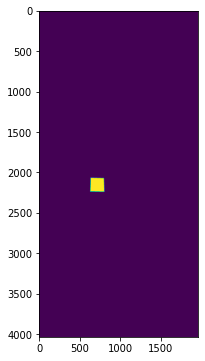

INTERSECTION & UNION


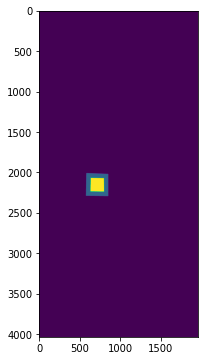

INTERSECTION


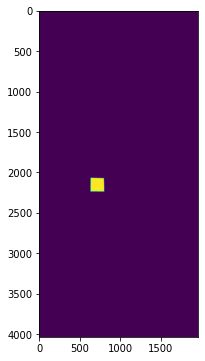

In [413]:
# We plot some analysis over the detected masks
print("ENCLOSED MARKER")
imshow(enclosed_mask)
print("UNENCLOSED MARKER")
imshow(unenclosed_mask)
print("ARUCO")
imshow(unenclosed_mask)
print("INTERSECTION & UNION")
imshow((unenclosed_mask + enclosed_mask + aruco_mask) / 3)
print("INTERSECTION")
imshow((unenclosed_mask * enclosed_mask * aruco_mask))

## Warp

### Line Correction

This warping only consider the **Aruco Detection** and does not rely on the SIFT Detection.
Basically, from the ordered contour of the marker we generate the two horizontal lines `[top|bottom]_left -> [top|bottom]_right` and the two vertical lines `top_[left|right] -> bottom_[left|right]` and we found their respective crossing points as vanishing points.

This methodology tends to offer better result than for the aruco board and since no sampling is needed, this algorithm is fully deterministic and is more computationaly efficient.

In [414]:
horizontal_lines = [
    [corners_ordered[0][0], corners_ordered[0][1]],
    [corners_ordered[0][3], corners_ordered[0][2]],
]
vertical_lines = [
    [corners_ordered[0][3], corners_ordered[0][0]],
    [corners_ordered[0][2], corners_ordered[0][1]],
]
vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)
vertical_hlines = to_homogenous_geometry(*vertical_edgelets)
horizontal_hlines = to_homogenous_geometry(*horizontal_edgelets)
vp_vert = np.cross(vertical_hlines[0], vertical_hlines[1])
vp_hor = np.cross(horizontal_hlines[0], horizontal_hlines[1])
image_result = warp_image(image, vp_vert, vp_hor, clip=True, clip_factor=3)

In [415]:
print(f"Warped Image Size: {image_result.shape}")
print(f"Infered Warped Image Size (If Clipping disabled): {infer_warp_shape(image, vp_vert, vp_hor)[::-1]}")

Warped Image Size: (4394, 2527, 3)
Infered Warped Image Size (If Clipping disabled): (4394, 2527)


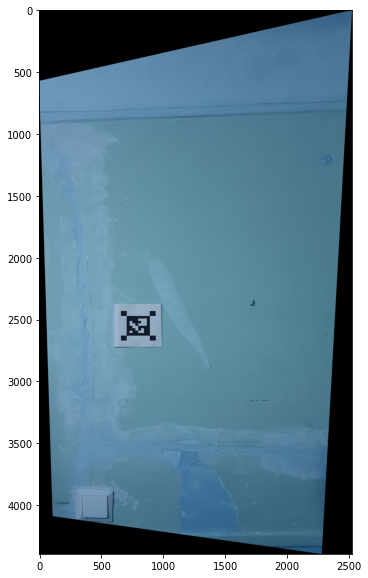

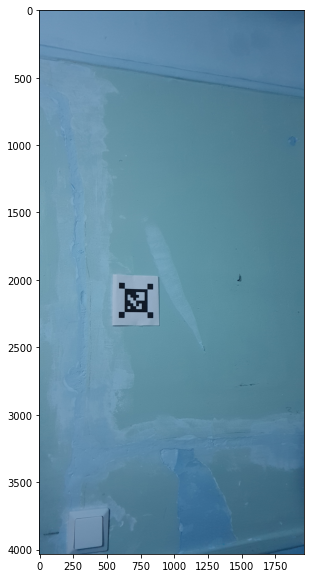

In [416]:
imshow(image_result, (10,10))
imshow(image, (10,10))

## Scale Bar

### matplotlib-scalebar

Our first attempt to build a scalebar will be done with a package found on github for this purpose,[`matplotlib-scalebar`](https://github.com/ppinard/matplotlib-scalebar). Full description of the package and its use is available on the repository.

In [274]:
from matplotlib_scalebar.scalebar import ScaleBar, SI_LENGTH_RECIPROCAL

But first we need to obtain the Aruco marker coordinates in the new projected plane, to do so we use the `marker_position_in_projection` function. This function has a similar behavior as `warp_image` and `infer_warp_shape` except it will reproject the position of the marker at the end.

In [417]:
reprojected_marker = marker_position_in_projection(
    image,
    vp_vert, 
    vp_hor, 
    corners_ordered[0],
    clip=True, 
    clip_factor=3
)

We can plot the newly generated coordinates `reprojected_marker` on the `image_result` to confirm the projection is correct

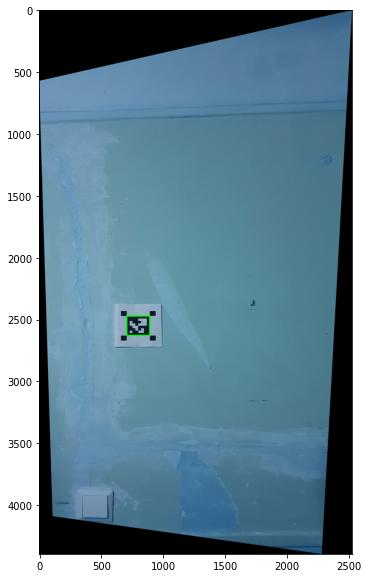

In [418]:
_ = draw_detector_borders(
    (image_result.copy()*255).astype(np.uint8), 
    reprojected_marker, 
    color=(0,255,0), 
    thickness=9, 
    draw=True,
    figsize=(10, 10)
)

Since we can confirm our reprojection works, we can now establish the scale ratio. We compute the marker height and width (in pixel) to identify the scale.

In [419]:
H_SIZE = abs(reprojected_marker[0][0] - reprojected_marker[1][0])
V_SIZE = abs(reprojected_marker[0][1] - reprojected_marker[-1][1])
# Matplotlib-scalebar expect values in meter
MARKER_SIZE_METER = 0.12
print("Height",H_SIZE, "Width", V_SIZE)

Height 185.56665 Width 157.2146


The following cell shows us the scalebar is functionnal and fully customizable but we can consider painful drawbacks. To draw the scalebar, the package first plot the image on matplotlib, creating a new figure with its set of parameters. Figures representing images via `plt.imshow` method or custom `imshow` function do not represent the real image, it is not the entire array that is plotted but a resized version of it. Leading to a decrease in size and accuracy. To keep the output shape we create the `image_save` function that force a predefined resolution `dpi`. Even if the saved image keep the same size, interpolation might alter the array. Besides, the function is computinally inneficient.

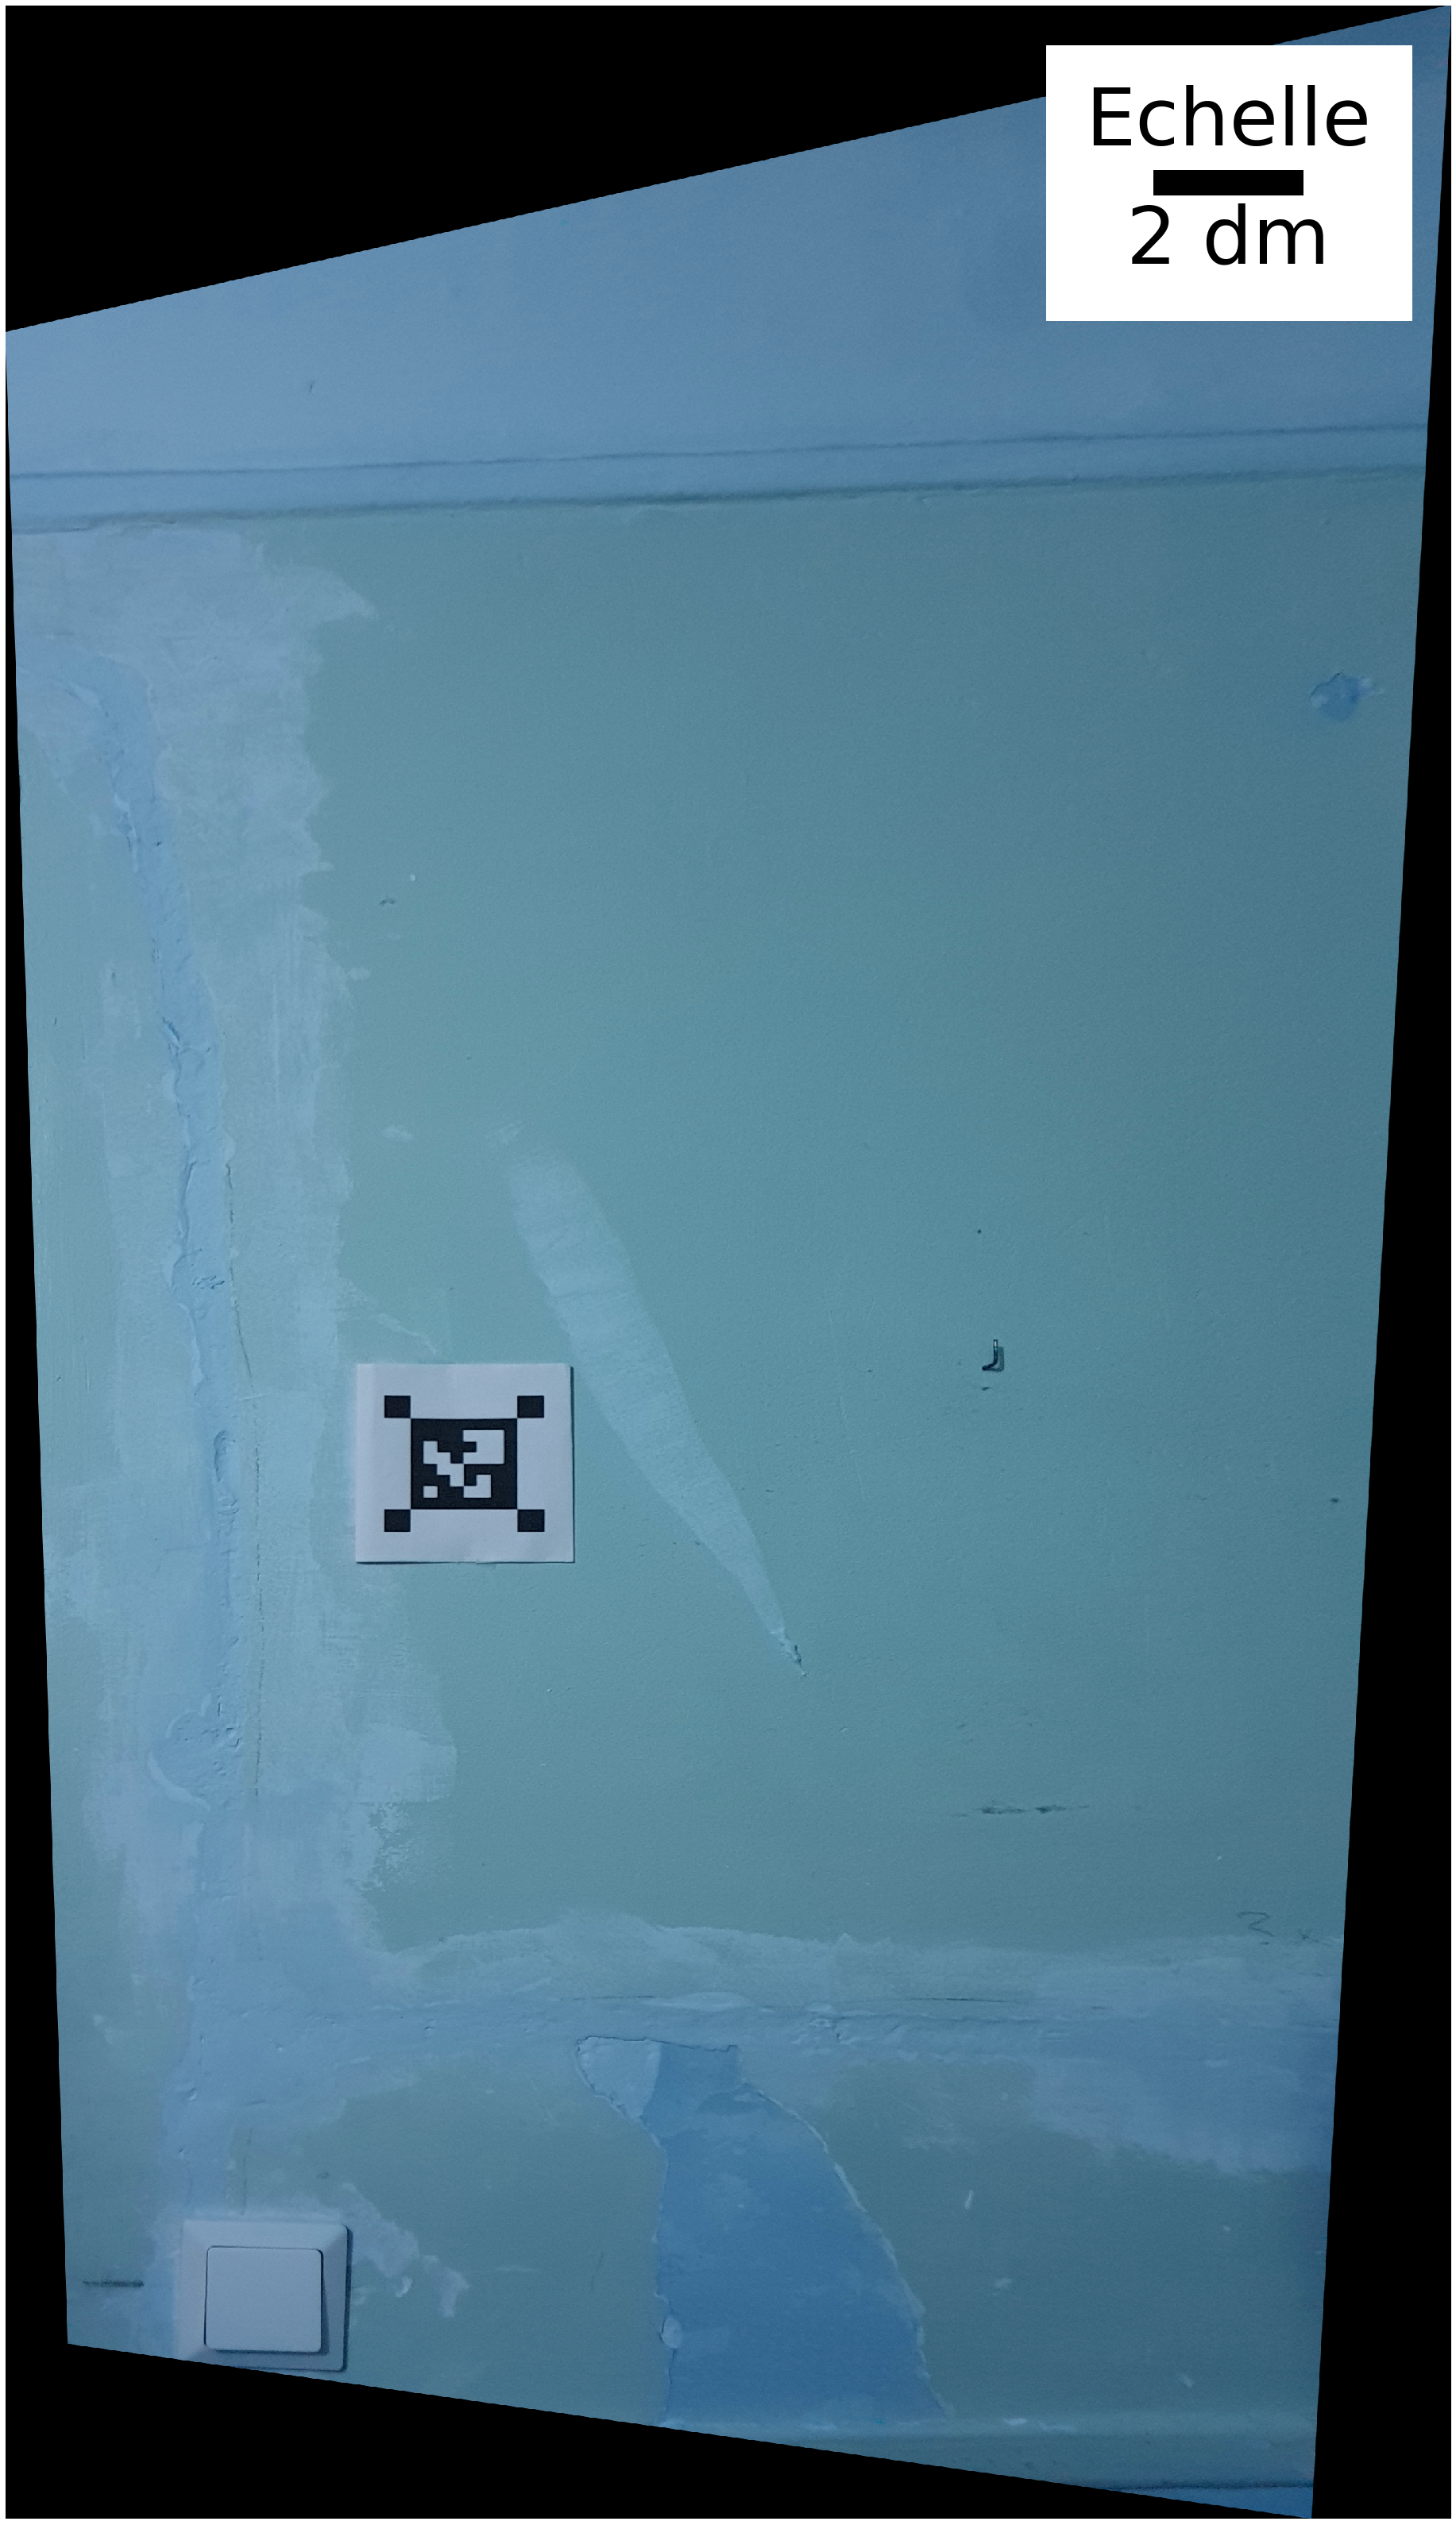

In [420]:
image_test = image_result.copy()

def image_save(image_test):
    height, width, nbands = image_test.shape
    dpi = 100
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image_test, interpolation='nearest')
    #for axis in fig.axes:
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)
    scalebar = ScaleBar(MARKER_SIZE_METER/int(V_SIZE), pad=dpi//20, border_pad=dpi//20, sep=dpi//10, location="upper right", label="Echelle", font_properties={'size':dpi})
    plt.gca().add_artist(scalebar)
    ax.set(xlim=[0, width], ylim=[height, 0], aspect=1)
    fig.savefig('fig.png', dpi=dpi, transparent=True)

image_save(image_test)

### Custom Scalebar

#### Exploration

##### Opening Image

In [421]:
# We create a copy of the array
image_test = (image_result*255).astype(np.uint8).copy()
# We store the image shape
HEIGHT, WIDTH, _ = image_test.shape
# Marker size in pixel in the reprojected plane
H_SIZE = abs(reprojected_marker[0][0] - reprojected_marker[1][0])
V_SIZE = abs(reprojected_marker[0][1] - reprojected_marker[-1][1])
# We indicate the size of the printed marker in the real world in millimeters
MARKER_SIZE_IN_MM = 120
# We compute distances in millimeters displayed in the image
# Disclaimer: Those distances are only relevant in the marker plane
FULL_PLAN_HEIGHT_MM = HEIGHT * MARKER_SIZE_IN_MM / H_SIZE
FULL_PLAN_WIDTH_MM = WIDTH * MARKER_SIZE_IN_MM / V_SIZE

In [367]:
FULL_PLAN_HEIGHT_MM, FULL_PLAN_WIDTH_MM

(4265.619172688799, 3207.2992414235573)

##### Setting up box parameters

In [368]:
# Considering every image will be different we'll need to use values relative to the image's shape
PADDING_H = 0.05
PADDING_W = 0.05
SIZE_H = 0.1
SIZE_W = 0.25
BOX_COLOR = (255,255,255)
BOX_THICKNESS = -1
BOX_LINETYPE = 8
BOX_POSITION = "upper_right"

In [369]:
# We compute each padding and we might select the min or max to have a unique border size for aesthetics
pad_h_px, pad_w_px = PADDING_H * HEIGHT, PADDING_W * WIDTH
pad_px = min(pad_h_px, pad_w_px)
pad_px

259.35

##### Computing box size and position

In [370]:
# We check the box size in pixel
size_h_px, size_w_px = SIZE_H * HEIGHT, SIZE_W * WIDTH
size_h_px, size_w_px

(688.6, 1296.75)

We can now compute the position of the box via 2 points, `top left` and `bottom right` corners depending on the `BOX_POSITION`

In [371]:
if BOX_POSITION == 'upper_right':
    tl_pt = (pad_px, WIDTH - pad_px - size_w_px)
    br_pt = (pad_px + size_h_px, WIDTH - pad_px)
elif BOX_POSITION == 'upper_left':
    tl_pt = (pad_px, pad_px)
    br_pt = (pad_px + size_h_px, pad_px + size_w_px)
elif BOX_POSITION == 'bottom_left':
    tl_pt = (HEIGHT-pad_px-size_h_px, pad_px)
    br_pt = (HEIGHT-pad_px, pad_px + size_w_px)
elif BOX_POSITION == 'bottom_right':
    tl_pt = (HEIGHT-pad_px-size_h_px, WIDTH - pad_px - size_w_px)
    br_pt = (HEIGHT-pad_px, WIDTH - pad_px)

tl_pt, br_pt = tuple(np.array(tl_pt).astype(int)), tuple(np.array(br_pt).astype(int))
tl_pt, br_pt

((259, 3630), (947, 4927))

##### Drawing background rectangle

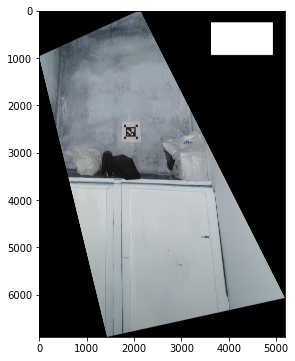

In [372]:
# First we draw the background rectangle
cv2.rectangle(
    img=image_test, 
    pt1=tl_pt[::-1], 
    pt2=br_pt[::-1], 
    color=BOX_COLOR, 
    thickness=BOX_THICKNESS, 
    lineType=BOX_LINETYPE, 
    shift=0
)
imshow(image_test)

##### Set up inbox parameters

Now we need to divide our box. 
- Height
    - Top padding equivalent to 5% of the box height
    - First Line equivalent to 30% of the box height -> For the scale word
    - Second Line equivalent to 30% of the box height -> For the scale line
    - Third Line equivalent to 30% of the box height -> For the scale value
    - Bottom padding equivalent to 5% of the box height

In [373]:
WORD = "Echelle"
INBOX_COLOR = (0,0,0)
INBOX_PADDING = 0.05
INBOX_WORD = 0.3
INBOX_LINE = 0.3
INBOX_VALUE = 0.3

In [374]:
INBOX_W_PAD = 0.05
inbox_w_pad_px = size_w_px * INBOX_W_PAD
inbox_w_pad_px

64.8375

In [375]:
inbox_pad_px = size_h_px * INBOX_PADDING
inbox_word_px = size_h_px * INBOX_WORD
inbox_line_px = size_h_px * INBOX_LINE
inbox_line_thickness_px = inbox_line_px / 3
inbox_value_px = size_h_px * INBOX_VALUE
inbox_pad_px, inbox_word_px, inbox_line_px, inbox_line_thickness_px, inbox_value_px

(34.43, 206.58, 206.58, 68.86, 206.58)

##### Compute Scalebar position and Drawing

In [376]:
# We compute the scalebar top-left and bottom-right corners
line_tl_pt = np.array(tl_pt) + np.array((inbox_pad_px + inbox_word_px + inbox_line_thickness_px, inbox_w_pad_px))
line_br_pt = np.array(br_pt) - np.array((inbox_pad_px + inbox_value_px + inbox_line_thickness_px, inbox_w_pad_px))
line_tl_pt = tuple(line_tl_pt.astype(int))
line_br_pt = tuple(line_br_pt.astype(int))
line_tl_pt, line_br_pt

((568, 3694), (637, 4862))

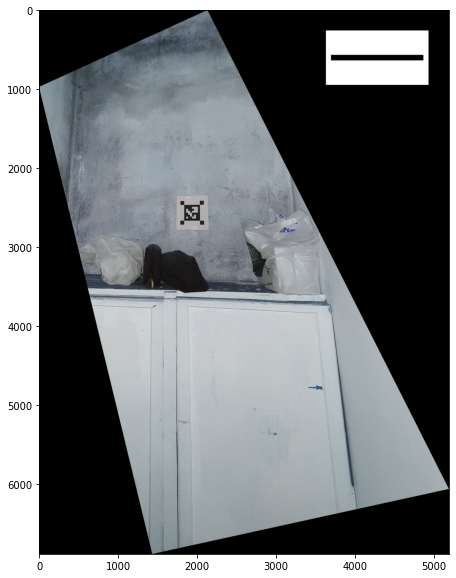

In [377]:
# We draw the scale line
cv2.rectangle(
    img=image_test, 
    pt1=line_tl_pt[::-1], 
    pt2=line_br_pt[::-1], 
    color=INBOX_COLOR, 
    thickness=BOX_THICKNESS, 
    lineType=BOX_LINETYPE, 
    shift=0
)
imshow(image_test, (10, 10))

##### Generate scale text

Now we need to focus on the text and the scale value. We have the `FULL_PLAN_HEIGHT_MM` and `FULL_PLAN_WIDTH_MM` to describe the scale. We need to display the best possible value.

In [380]:
def replace_values_in_string(text, args_dict):
    for key in args_dict.keys():
        text = text.replace(key, str(args_dict[key]))
    return text

In [381]:
# We create a dictionnary to provide units and metric subdivision
METER_SUBDIVISION_DICT = {
    'e+00':' mm',
    'e+01':' cm',
    'e+02':' dm',
    'e+03':' m',
    'e+04':' dam',
    'e+05':' hm',
    'e+06':' km'
}

In [378]:
# Black bar size
black_bar_scale_mm = (line_br_pt[1] - line_tl_pt[1]) / HEIGHT * FULL_PLAN_HEIGHT_MM

In [382]:
# As we see scientific notation ends with e+XX
np.format_float_scientific(black_bar_scale_mm, precision=1)

'7.2e+02'

In [383]:
# We use our units dictionnary to format the text
value_str = replace_values_in_string(
    np.format_float_scientific(black_bar_scale_mm, precision=1),
    METER_SUBDIVISION_DICT
)
value_str

'7.2 dm'

In [385]:
# Given the size of the inbox available for text we look for the best fontSize possible for the lower string
for i in range(16):
    resulting_size = cv2.getTextSize(value_str,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=i+1, thickness=10)
    if resulting_size[0][0] > abs(line_br_pt[1] - line_tl_pt[1]) or resulting_size[0][1] > inbox_value_px:
        break
print("fontScale to Use", i)
VALUE_FONT_SCALE = i
resulting_size = cv2.getTextSize(value_str,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=VALUE_FONT_SCALE, thickness=3)

fontScale to Use 9


In [389]:
# We compute the text position to have it horitontally aligned in the box
value_text_origin_pt = np.array(line_tl_pt) + (inbox_line_thickness_px*2 + inbox_word_px, abs(line_br_pt[1] - line_tl_pt[1])/2 - resulting_size[0][0]/2 )
value_text_origin_pt = tuple(np.array(value_text_origin_pt).astype(int))

##### Drawing scale text

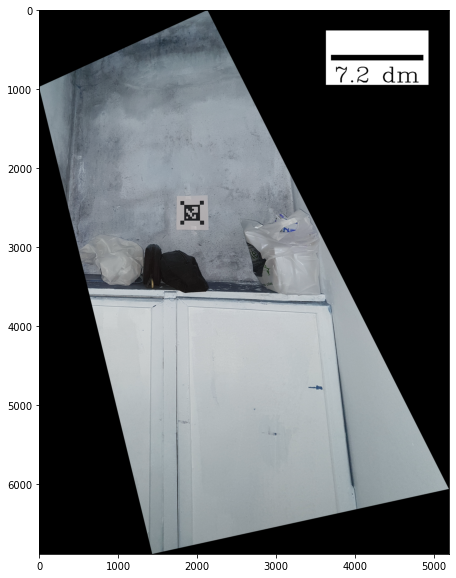

In [391]:
cv2.putText(
    img=image_test,
    text=value_str,
    org = value_text_origin_pt[::-1],
    fontFace=cv2.FONT_HERSHEY_COMPLEX,
    fontScale=VALUE_FONT_SCALE,
    color=INBOX_COLOR,
    thickness=10
)
imshow(image_test, (10,10))

##### Computing legend word position

In [392]:
# Given the size of the inbox available for text we look for the best fontSize possible for the upper string
for i in range(16):
    resulting_word_size = cv2.getTextSize(WORD,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=i+1, thickness=10)
    if resulting_word_size[0][0] > abs(line_br_pt[1] - line_tl_pt[1]) or resulting_word_size[0][1] > inbox_word_px:
        break
print("fontScale to Use", i)
VALUE_FONT_SCALE = i
resulting_word_size = cv2.getTextSize(WORD,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=VALUE_FONT_SCALE, thickness=10)

fontScale to Use 9


In [393]:
# We compute the text position to have it horitontally aligned in the box
word_text_origin_pt = np.array(line_tl_pt) - (inbox_line_thickness_px, abs(line_br_pt[1] - line_tl_pt[1])/2 - resulting_word_size[0][0]/2 )
word_text_origin_pt = tuple(np.array(word_text_origin_pt).astype(int))

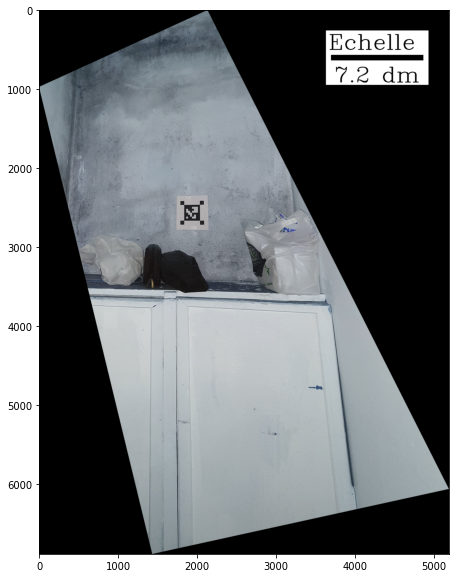

In [394]:
cv2.putText(
    img=image_test,
    text=WORD,
    org = word_text_origin_pt[::-1],
    fontFace=cv2.FONT_HERSHEY_COMPLEX,
    fontScale=VALUE_FONT_SCALE,
    color=INBOX_COLOR,
    thickness=10
)
imshow(image_test, (10,10))

#### Performance

In [446]:
%%time
# THIS CELL IS HUGE AND CORRESPOND TO ALL THE CODE WROTE PREVIOUSLY
# IT IS DONE SO TO MEASURE THE PERFORMANCE OF THIS METHODOLOGY OVER THE SCALEBAR PLUGIN

# We create a copy of the array
image_test = (image_result*255).astype(np.uint8).copy()
# Marker size in pixel
H_SIZE = abs(reprojected_marker[0][0] - reprojected_marker[1][0])
V_SIZE = abs(reprojected_marker[0][1] - reprojected_marker[-1][1])
HEIGHT, WIDTH, _ = image_test.shape
MARKER_SIZE_IN_MM = 120
FULL_PLAN_HEIGHT_MM = HEIGHT * MARKER_SIZE_IN_MM / H_SIZE
FULL_PLAN_WIDTH_MM = WIDTH * MARKER_SIZE_IN_MM / V_SIZE
# Considering every image will be different we'll need to use values relative to the image's shape
PADDING_H = 0.05
PADDING_W = 0.05
SIZE_H = 0.1
SIZE_W = 0.25
BOX_COLOR = (255,255,255)
BOX_THICKNESS = -1
BOX_LINETYPE = 8
BOX_POSITION = "bottom_right"
# We compute each padding and we might select the min or max to have a unique border size for aesthetics
pad_h_px, pad_w_px = PADDING_H * HEIGHT, PADDING_W * WIDTH
pad_px = min(pad_h_px, pad_w_px)
size_h_px, size_w_px = SIZE_H * HEIGHT, SIZE_W * WIDTH
if BOX_POSITION == 'upper_right':
    tl_pt = (pad_px, WIDTH - pad_px - size_w_px)
    br_pt = (pad_px + size_h_px, WIDTH - pad_px)
elif BOX_POSITION == 'upper_left':
    tl_pt = (pad_px, pad_px)
    br_pt = (pad_px + size_h_px, pad_px + size_w_px)
elif BOX_POSITION == 'bottom_left':
    tl_pt = (HEIGHT-pad_px-size_h_px, pad_px)
    br_pt = (HEIGHT-pad_px, pad_px + size_w_px)
elif BOX_POSITION == 'bottom_right':
    tl_pt = (HEIGHT-pad_px-size_h_px, WIDTH - pad_px - size_w_px)
    br_pt = (HEIGHT-pad_px, WIDTH - pad_px)

tl_pt, br_pt = tuple(np.array(tl_pt).astype(int)), tuple(np.array(br_pt).astype(int))
cv2.rectangle(
    img=image_test, 
    pt1=tl_pt[::-1], 
    pt2=br_pt[::-1], 
    color=BOX_COLOR, 
    thickness=BOX_THICKNESS, 
    lineType=BOX_LINETYPE, 
    shift=0
)
WORD = "Echelle"
INBOX_COLOR = (0,0,0)
INBOX_PADDING = 0.05
INBOX_WORD = 0.3
INBOX_LINE = 0.3
INBOX_VALUE = 0.3
INBOX_W_PAD = 0.05
inbox_w_pad_px = size_w_px * INBOX_W_PAD
inbox_pad_px = size_h_px * INBOX_PADDING
inbox_word_px = size_h_px * INBOX_WORD
inbox_line_px = size_h_px * INBOX_LINE
inbox_line_thickness_px = inbox_line_px / 3
inbox_value_px = size_h_px * INBOX_VALUE
line_tl_pt = np.array(tl_pt) + np.array((inbox_pad_px + inbox_word_px + inbox_line_thickness_px, inbox_w_pad_px))
line_br_pt = np.array(br_pt) - np.array((inbox_pad_px + inbox_value_px + inbox_line_thickness_px, inbox_w_pad_px))
line_tl_pt = tuple(line_tl_pt.astype(int))
line_br_pt = tuple(line_br_pt.astype(int))
cv2.rectangle(
    img=image_test, 
    pt1=line_tl_pt[::-1], 
    pt2=line_br_pt[::-1], 
    color=INBOX_COLOR, 
    thickness=BOX_THICKNESS, 
    lineType=BOX_LINETYPE, 
    shift=0
)
# Black bar size
black_bar_scale_mm = (line_br_pt[1] - line_tl_pt[1]) / HEIGHT * FULL_PLAN_HEIGHT_MM
value_str = replace_values_in_string(
    np.format_float_scientific(black_bar_scale_mm, precision=1),
    METER_SUBDIVISION_DICT
)
for i in range(16):
    resulting_size = cv2.getTextSize(value_str,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=i+1, thickness=10)
    if resulting_size[0][0] > abs(line_br_pt[1] - line_tl_pt[1]) or resulting_size[0][1] > inbox_value_px:
        break
print("fontScale to Use", i)
VALUE_FONT_SCALE = i
resulting_size = cv2.getTextSize(value_str,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=VALUE_FONT_SCALE, thickness=10)
value_text_origin_pt = line_br_pt - np.array( inbox_line_thickness_px +inbox_word_px, (abs(line_br_pt[1] - line_tl_pt[1]) - resulting_size[0][1])/2 )
value_text_origin_pt = tuple(np.array(value_text_origin_pt).astype(int))
value_text_origin_pt = np.array(line_tl_pt) + (inbox_line_thickness_px*2 + inbox_word_px, abs(line_br_pt[1] - line_tl_pt[1])/2 - resulting_size[0][0]/2 )
value_text_origin_pt = tuple(np.array(value_text_origin_pt).astype(int))
cv2.putText(
    img=image_test,
    text=value_str,
    org = value_text_origin_pt[::-1],
    fontFace=cv2.FONT_HERSHEY_COMPLEX,
    fontScale=VALUE_FONT_SCALE,
    color=INBOX_COLOR,
    thickness=10
)
for i in range(16):
    resulting_word_size = cv2.getTextSize(WORD,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=i+1, thickness=10)
    if resulting_word_size[0][0] > abs(line_br_pt[1] - line_tl_pt[1]) or resulting_word_size[0][1] > inbox_word_px:
        break
print("fontScale to Use", i)
WORD_FONT_SCALE = i
resulting_word_size = cv2.getTextSize(WORD,fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=WORD_FONT_SCALE, thickness=10)
word_text_origin_pt = np.array(line_tl_pt) - (inbox_line_thickness_px,- abs(line_br_pt[1] - line_tl_pt[1])/2 + resulting_word_size[0][0]/2 )
word_text_origin_pt = tuple(np.array(word_text_origin_pt).astype(int))
_ = cv2.putText(
    img=image_test,
    text=WORD,
    org = word_text_origin_pt[::-1],
    fontFace=cv2.FONT_HERSHEY_COMPLEX,
    fontScale=VALUE_FONT_SCALE,
    color=INBOX_COLOR,
    thickness=10
)

fontScale to Use 4
fontScale to Use 4
CPU times: user 114 ms, sys: 115 ms, total: 229 ms
Wall time: 230 ms


On a MacBook Pro 2019 (1.6GHz), this method Wall time is `230ms` ~170x faster than `matplotlib-scalebar` without degrading the image size or resolution.

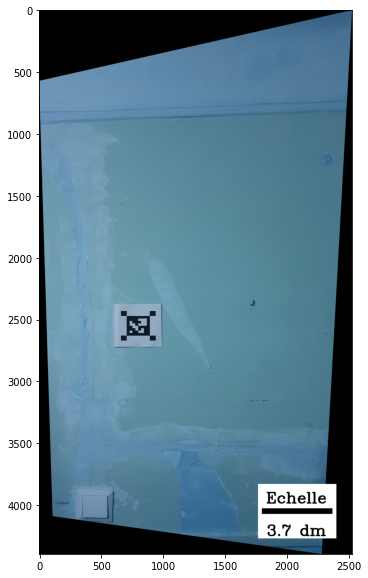

In [447]:
imshow(image_test, (10,10))